In [1]:
# Import of all libraries
import pandas as pd
import numpy as np
import pymysql

# SQL imports
import sqlalchemy
from sqlalchemy import create_engine
import getpass
password = getpass.getpass()

# Graph and Map imports
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

········


In [2]:
# Creating Connection String
connection_string = 'mysql+pymysql://root:' + password + '@localhost/house_price_regression'
engine = create_engine(connection_string)

# Database Import and Dataframe Building

In [3]:
# Import of CSV
housepricedf = pd.read_csv('regression_data_clean.csv')

In [4]:
print("The housepricedf shape is:", housepricedf.shape) 

print("Initial info about housepricedf")
housepricedf.info()


The housepricedf shape is: (21597, 21)
Initial info about housepricedf
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 no

#Notes
- To test some of our initial theories, we needed to create some extra columns which was done throughy SQL

- The following queries provide: \
    -renovation: if a house has been renovated or not \
    -expensive: if a house was more than '650k' returned '1' and else '0' \
    -price_sqft_lot: the average price per sqft_lot \
    -price_sqft_living: the average price per sqft_living

# SQL Queries

In [5]:
# Categorize year renovated 1 or 0 (if it has been renovated it will give 1, and if it has \
# not been renovated 0)

query2 = 'select \
case \
when yr_renovated=0 then 0 \
else 1 \
end as renovation \
from house_price_data;'

data_query2 = pd.read_sql_query(query2, engine)
data_query2 

,renovation
0,0
1,1
2,0
3,0
4,0
...,...
21592,0
21593,0
21594,0
21595,0


#Note
- One of our theories revolved around the age of the house
- We created a column to calculate the difference between 2015 and of the year_built

In [6]:
# How many years since the house has been renovated?

housepricedf['house_age'] = 2015 - housepricedf['yr_built']
housepricedf.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,60
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,64
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,180000,82
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,...,910,1965,0,98136,47.5208,-122.393,1360,5000,604000,50
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,510000,28


In [7]:
# Putting all df's together to 'Hsedata' df
hsedata = pd.concat([housepricedf, data_query2], axis=1)
hsedata

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age,renovation
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1955,0,98178,47.5112,-122.257,1340,5650,221900,60,0
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,538000,64,1
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,...,1933,0,98028,47.7379,-122.233,2720,8062,180000,82,0
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,...,1965,0,98136,47.5208,-122.393,1360,5000,604000,50,0
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,...,1987,0,98074,47.6168,-122.045,1800,7503,510000,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/14,3,2.50,1530,1131,3.0,0,0,3,...,2009,0,98103,47.6993,-122.346,1530,1509,360000,6,0
21593,6600060120,2/23/15,4,2.50,2310,5813,2.0,0,0,3,...,2014,0,98146,47.5107,-122.362,1830,7200,400000,1,0
21594,1523300141,6/23/14,2,0.75,1020,1350,2.0,0,0,3,...,2009,0,98144,47.5944,-122.299,1020,2007,402101,6,0
21595,291310100,1/16/15,3,2.50,1600,2388,2.0,0,0,3,...,2004,0,98027,47.5345,-122.069,1410,1287,400000,11,0


#Note
- In order to deal with datetime column we decided to bin it into quarters to see if there was any correaltion to price. 
- The idea being that price could be based on seasonality

In [8]:
# Converting 'date' column to datetime and checking type of column
hsedata['date'] = pd.to_datetime(hsedata['date'])

print("date column type now is :", hsedata['date'].dtypes)

date column type now is : datetime64[ns]


In [9]:
# Creating of month and quarter columns for our dataframe
hsedata['month'] = hsedata['date'].dt.month
hsedata['quarter'] = hsedata['date'].dt.quarter

In [10]:
# Setting id as index for hsedata1 df
hsedata = hsedata.set_index(['id'], drop = True)

In [11]:
# A sanity check of our newly formed and formatted hsedata dataframe
hsedata

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_age,renovation,month,quarter
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,...,98178,47.5112,-122.257,1340,5650,221900,60,0,10,4
6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,...,98125,47.7210,-122.319,1690,7639,538000,64,1,12,4
5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,...,98028,47.7379,-122.233,2720,8062,180000,82,0,2,1
2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,...,98136,47.5208,-122.393,1360,5000,604000,50,0,12,4
1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,...,98074,47.6168,-122.045,1800,7503,510000,28,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,8,...,98103,47.6993,-122.346,1530,1509,360000,6,0,5,2
6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,8,...,98146,47.5107,-122.362,1830,7200,400000,1,0,2,1
1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,7,...,98144,47.5944,-122.299,1020,2007,402101,6,0,6,2


# DATA EXPLORATION

# Mapping / Location
- One of the first things we noticed and wanted to flesh out was the inlcusion of the Lat and Long columns.

<Figure size 720x720 with 0 Axes>

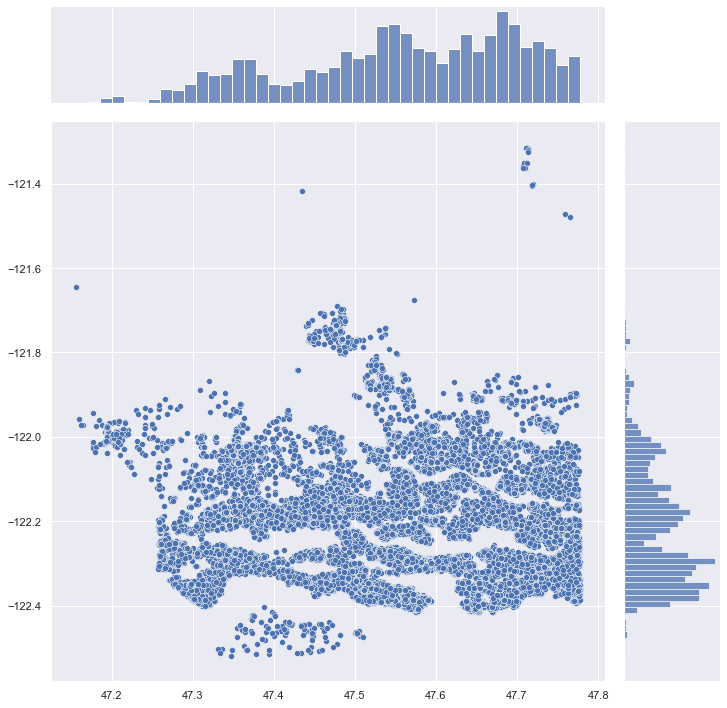

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [12]:
# Mapping out the Lat and Long data to see what the distribution looks like
plt.figure(figsize = (10,10))
sns.jointplot(x=hsedata.lat.values, y = hsedata.long.values, height = 10)
plt.ylabel('Longitude', fontsize = 12)
plt.xlabel('Latitude', fontsize = 12)
plt.show()
sns.despine

- Notice high distribution between -122.4 / -122.2 Long values and 47.6 / 47.7  lat values
- With this we want to find a way to bin these values to find out if there was a correlation between price and location

# Binning of Lat and Long columns

In [13]:
# Creating copy of hsedata into hsedata1
hsedata1 = hsedata.copy()

In [14]:
# Creating bins for 'lat' columns 
bin_labels = ['1','2','3','4','5','6','7','8','9','10','11']
cut_bins = [47.1558, 47.20, 47.25, 47.30, 47.35, 47.40, 47.45, 47.4711, 47.5718, 47.60, 47.6780,47.7777]
hsedata1['latbin'] = pd.cut(hsedata1['lat'], bins = cut_bins, labels = bin_labels)

In [15]:
# Creating bins for 'long' columns
bin_labels = ['1','2','3','4','5']
cut_bins = [-122.52, -122.50, -122.328, -122.231, -122.125, -121.12]
hsedata1['longbin'] = pd.cut(hsedata1['long'], bins = cut_bins, labels = bin_labels)

In [16]:
# Checking created columns 
print("latbin values: ", list(hsedata1['latbin'].unique()))
print("longbin values: ", list(hsedata1['longbin'].unique()))

latbin values:  ['8', '11', '10', '4', '6', '5', '9', '3', '7', '2', '1']
longbin values:  ['3', '2', '5', '4', '1']


In [17]:
# sanity check after column creations
hsedata1

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,long,sqft_living15,sqft_lot15,price,house_age,renovation,month,quarter,latbin,longbin
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,...,-122.257,1340,5650,221900,60,0,10,4,8,3
6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,...,-122.319,1690,7639,538000,64,1,12,4,11,3
5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,...,-122.233,2720,8062,180000,82,0,2,1,11,3
2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,...,-122.393,1360,5000,604000,50,0,12,4,8,2
1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,...,-122.045,1800,7503,510000,28,0,2,1,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,8,...,-122.346,1530,1509,360000,6,0,5,2,11,2
6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,8,...,-122.362,1830,7200,400000,1,0,2,1,8,2
1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,7,...,-122.299,1020,2007,402101,6,0,6,2,9,3


# Clustering method
#Note
- We also wanted to have an alternative column which would cluster locations by closeness
- We went with a model known as "Kmeans"
    - KMeans takes into account the mean value of certain clusters and groups our dataset accordingly
- With this we can test to see if the location affects the price of the house

In [18]:
# Creating Elbow curve to determine number of K clusters to use
X=hsedata1.loc[:,['zipcode','lat','long']]

In [19]:
hsedata1.dropna(axis=0,how='any',subset=['lat','long'],inplace=True)

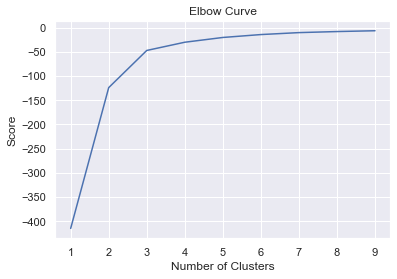

In [20]:
# Plotting elbow curve to determine the number of clusters to be used in calculting KMeans

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = hsedata1[['lat']]
X_axis = hsedata1[['long']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [21]:
# Creating 'XL' for mapping
XL = hsedata1[['zipcode','lat','long']]

In [22]:
# Calculating KMeans
kmeans = KMeans(n_clusters = 3, init = "k-means++", random_state = 100)

# Computes k-means clustering
kmeans.fit(XL[XL.columns[1:3]])

# Creating extra column for XL df
XL["cluster"] = kmeans.fit_predict(XL[XL.columns[1:3]])

#Center coordinates
centers = kmeans.cluster_centers_

#Label for each point
labels = kmeans.predict(XL[XL.columns[1:3]])

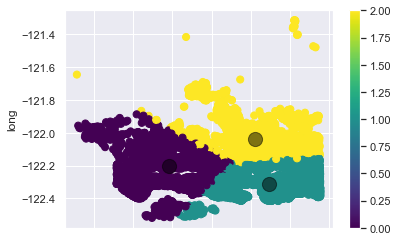

In [23]:
# Plotting clusters data
XL.plot.scatter(x = 'lat', y = 'long', c=labels, s=50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s=200, alpha=0.5)

In [24]:
# Creating variable cluster to store new clusters
cluster = XL.drop(['zipcode','lat','long'], axis =1)
cluster

,cluster
id,
7129300520,0
6414100192,1
5631500400,1
2487200875,1
1954400510,2
...,...
263000018,1
6600060120,1
1523300141,1


In [25]:
# Merging df's 'hsedata1', 'cluster', into 'hsefinal'
hsefinal = pd.concat([hsedata1, cluster], axis = 1)

In [26]:
# Sanity check of 'hsefinal' df
hsefinal

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,price,house_age,renovation,month,quarter,latbin,longbin,cluster
id,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,...,1340,5650,221900,60,0,10,4,8,3,0
6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,...,1690,7639,538000,64,1,12,4,11,3,1
5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,...,2720,8062,180000,82,0,2,1,11,3,1
2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,...,1360,5000,604000,50,0,12,4,8,2,1
1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,...,1800,7503,510000,28,0,2,1,10,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,8,...,1530,1509,360000,6,0,5,2,11,2,1
6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,8,...,1830,7200,400000,1,0,2,1,8,2,1
1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,7,...,1020,2007,402101,6,0,6,2,9,3,1


#Note
- Spot checking some of our columns scatter plots in relation to price - bedrooms, sqft_living, grade, latbins, longbins

In [27]:
hsefinal['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

# Working on Numerical Columns

In [28]:
# Filtering out identified numerical columns - nums_hsefinal
nums = hsefinal.drop(['date','renovation'], axis = True)
nums

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,long,sqft_living15,sqft_lot15,price,house_age,month,quarter,latbin,longbin,cluster
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-122.257,1340,5650,221900,60,10,4,8,3,0
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-122.319,1690,7639,538000,64,12,4,11,3,1
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,-122.233,2720,8062,180000,82,2,1,11,3,1
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,-122.393,1360,5000,604000,50,12,4,8,2,1
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,-122.045,1800,7503,510000,28,2,1,10,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,-122.346,1530,1509,360000,6,5,2,11,2,1
6600060120,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,-122.362,1830,7200,400000,1,2,1,8,2,1
1523300141,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,-122.299,1020,2007,402101,6,6,2,9,3,1


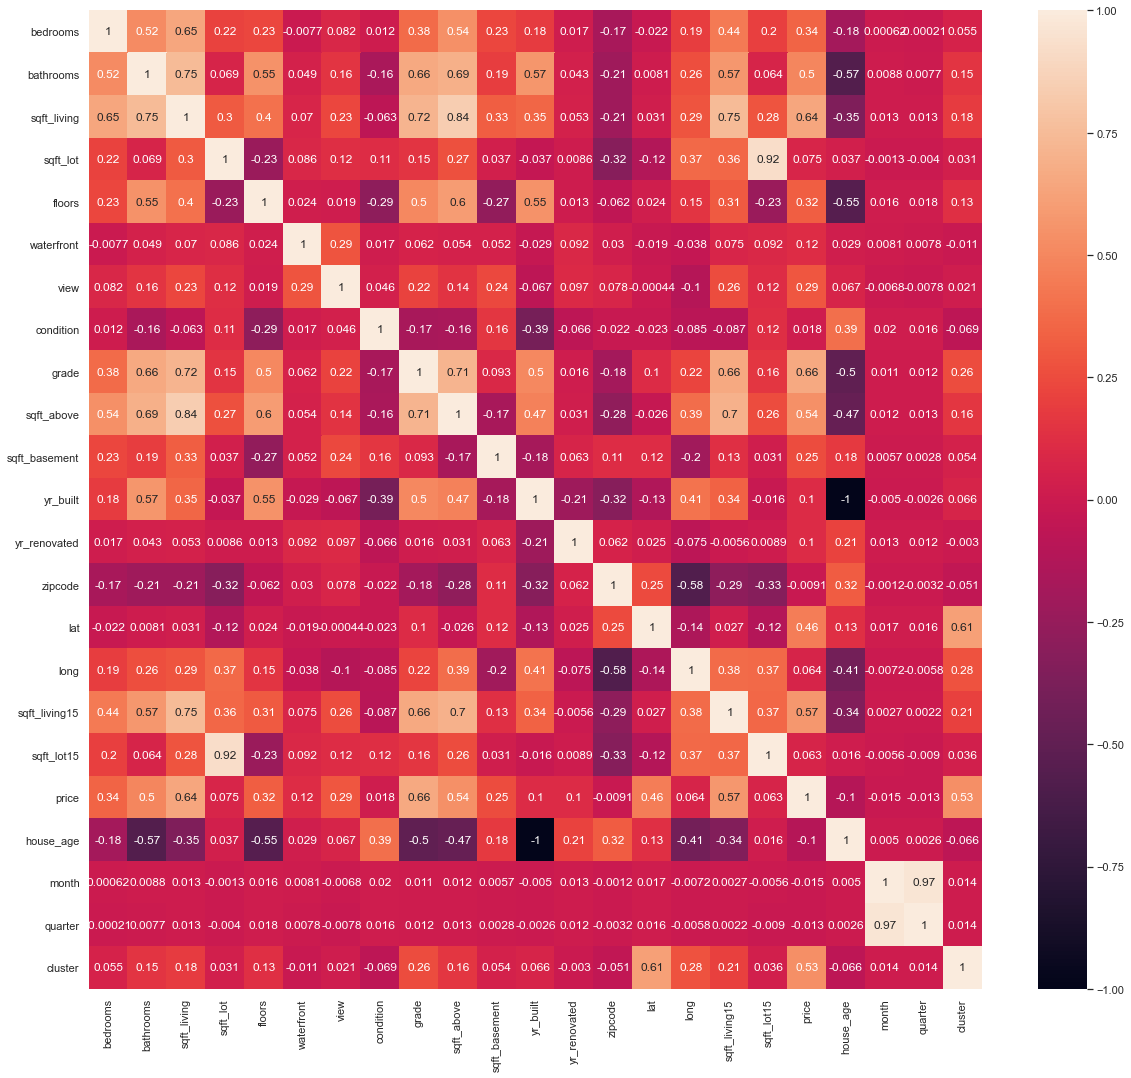

In [29]:
# Checking for multicollinearity of numerical data
corr_matrix = nums.corr(method = 'spearman')
fig, ax = plt.subplots(figsize = (20,18))
ax = sns.heatmap(corr_matrix, annot = True)
plt.show()

In [30]:
# Checking collinearity of columns vs price
numscorr = nums.corr(method = 'spearman') # variable of the corr matrix using spearman
numscorr['price'] # Isolates 'price' column for easier viewing of its relation to other features

bedrooms         0.344245
bathrooms        0.497298
sqft_living      0.643993
sqft_lot         0.075071
floors           0.322482
waterfront       0.115119
view             0.293906
condition        0.017995
grade            0.658152
sqft_above       0.541563
sqft_basement    0.251491
yr_built         0.102058
yr_renovated     0.101830
zipcode         -0.009084
lat              0.456126
long             0.064058
sqft_living15    0.572263
sqft_lot15       0.063076
price            1.000000
house_age       -0.102058
month           -0.015276
quarter         -0.013445
cluster          0.532384
Name: price, dtype: float64

#Note
- Using the spearman method to plot the correlation matrix we can get an idea of features \
that we want to use to determine price, our independent variable
- With this we can also start to work on some of our initial theories about house_age \
location (using KMeans and binning method)
- Given Data with high correlation w/ price: \
    -bedrooms, bathrooms, sqft_living, floors, view,  
    grade, sqft_above, sqft_basement, lat, sqft_living15, 
- Created columns with high correlation w/ price: \
    -price_sqft_lot, price_sqft_living, and cluster

# Regression Analysis of all features
- We want to get a benchmark model that inlcudes all features so \
that we can see if other models improve or worsen the outcome
- We will be using both the Linear Regression and Random Forest Regressor models

In [31]:
# Importing of libraries
# Model imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [32]:
# Splitting our model into train and test
y = hsefinal['price']
X = hsefinal.drop(['price','date'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [33]:
# Using the linear regression

lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

lm_predictions = lm_model.predict(X_test)

# Model Metrics 

In [34]:
# Import of metric libraries
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


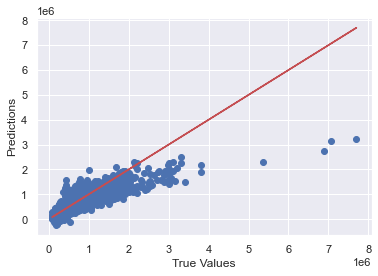

In [35]:
# Mapping the model using the y_test and predictions

plt.scatter(y_test, lm_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Ideal predictions plot
plt.plot(y_test,y_test,'r')

In [36]:
# Time to get our first model metrics to be used as a benchmark

MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.5f" % (R2))

The mean absolute error of the model in the test set is: 123326.72
The mean squared error of the model in the test set is: 44172097416.31
The root mean squared error of the model in the test set is: 210171.59
The R2 of the model in the test set is: 0.69831


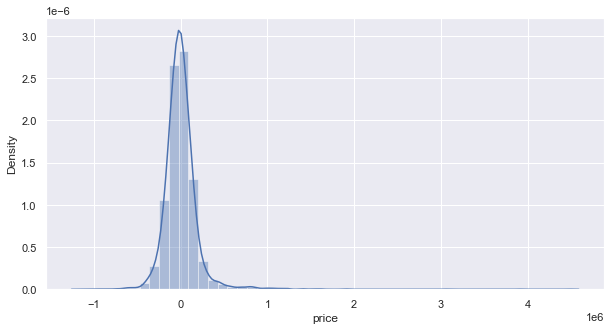

In [37]:
# Plotting residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- lm_predictions)
sns.distplot(residuals)

In [38]:
#Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    
# Train the model on training data
rf.fit(X_train,y_train)   

RandomForestRegressor(n_estimators=1000, random_state=42)

In [39]:
# Use the forest's predict method on the test data
tree_predictions = rf.predict(X_test)

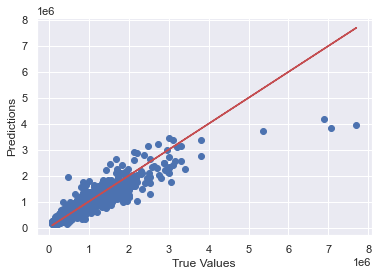

In [40]:
plt.scatter(y_test, tree_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot(y_test,y_test,'r')

In [41]:
MAE = mean_absolute_error(y_test,tree_predictions)
MSE = mean_squared_error(y_test,tree_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,tree_predictions)

print("the mean absolut error of the model in the test set is: %6.2f" % (MAE))
print("the mean squared error of the model in the test set is: %6.2f" % (MSE))
print("the root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("the R2 of the model in the test set is: %4.5f" % (R2))

the mean absolut error of the model in the test set is: 70221.71
the mean squared error of the model in the test set is: 20085479402.93
the root mean squared error of the model in the test set is: 141723.25
the R2 of the model in the test set is: 0.86282


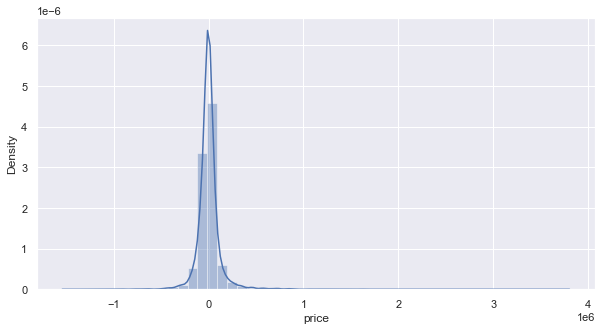

In [42]:
# Plotting residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- tree_predictions)
sns.distplot(residuals)

- Linear regression R2 score = 0.69
- Random Tree Regressor R2 score = 0.86

In [43]:
# To work on KFolds analysis for overfitting

# Feature Selection
#Note

- Using the decision tree regressor we work out finding which features contribute the most to price 

In [44]:
# Importing DecisionTreeRegressor library
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

In [45]:
# Define the model with DecisionTreeRegressor
model = DecisionTreeRegressor()

# fit the model
model.fit(X_train,y_train)

DecisionTreeRegressor()

0.0026267938103631656
Feature: 0, Score: 0.00263
Feature: 1, Score: 0.01139
Feature: 2, Score: 0.20846
Feature: 3, Score: 0.01125
Feature: 4, Score: 0.00063
Feature: 5, Score: 0.04944
Feature: 6, Score: 0.00671
Feature: 7, Score: 0.00286
Feature: 8, Score: 0.34867
Feature: 9, Score: 0.02626
Feature: 10, Score: 0.00679
Feature: 11, Score: 0.01333
Feature: 12, Score: 0.00145
Feature: 13, Score: 0.01240
Feature: 14, Score: 0.16437
Feature: 15, Score: 0.07148
Feature: 16, Score: 0.02953
Feature: 17, Score: 0.01562
Feature: 18, Score: 0.00676
Feature: 19, Score: 0.00114
Feature: 20, Score: 0.00422
Feature: 21, Score: 0.00106
Feature: 22, Score: 0.00079
Feature: 23, Score: 0.00050
Feature: 24, Score: 0.00227


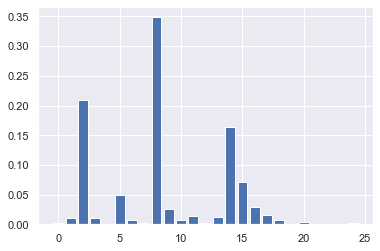

In [46]:
importance = model.feature_importances_

print(importance[0])

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [47]:
# creating variable for columns in hsefinal df
len(list(hsefinal.columns))

27

In [48]:
cols = (list(hsefinal.columns))

In [49]:
cols.pop(0) # Removing date from cols

'date'

In [50]:
cols.pop(18) # Removing price from cols

'price'

In [51]:
# Creating dictionary of values 
dict1 = {feature: v for feature, v in enumerate(importance)}

dict2 = {}
for i, col in enumerate(cols):
    dict2[col] = dict1[i]

In [52]:
dict2

{'bedrooms': 0.0026267938103631656,
 'bathrooms': 0.011390432330234504,
 'sqft_living': 0.2084587471604242,
 'sqft_lot': 0.011253049629599809,
 'floors': 0.0006269736486251271,
 'waterfront': 0.04944438952036008,
 'view': 0.00671142294278248,
 'condition': 0.00285600660466417,
 'grade': 0.3486655522862472,
 'sqft_above': 0.026262335200063155,
 'sqft_basement': 0.006787328536612516,
 'yr_built': 0.013327943537558931,
 'yr_renovated': 0.0014495203070520367,
 'zipcode': 0.01240084827530932,
 'lat': 0.16437267803445615,
 'long': 0.07147873457693696,
 'sqft_living15': 0.029529672029819452,
 'sqft_lot15': 0.015615814049610086,
 'house_age': 0.006761789574142762,
 'renovation': 0.0011398708461617748,
 'month': 0.004220441839515645,
 'quarter': 0.0010625908983230763,
 'latbin': 0.0007903557771195723,
 'longbin': 0.0004951356156675115,
 'cluster': 0.0022715729683503937}

In [53]:
# Arranging by weight of feature
feature_weight = sorted(dict2.items(), key=lambda x: x[1], reverse = True)
feature_weight

[('grade', 0.3486655522862472),
 ('sqft_living', 0.2084587471604242),
 ('lat', 0.16437267803445615),
 ('long', 0.07147873457693696),
 ('waterfront', 0.04944438952036008),
 ('sqft_living15', 0.029529672029819452),
 ('sqft_above', 0.026262335200063155),
 ('sqft_lot15', 0.015615814049610086),
 ('yr_built', 0.013327943537558931),
 ('zipcode', 0.01240084827530932),
 ('bathrooms', 0.011390432330234504),
 ('sqft_lot', 0.011253049629599809),
 ('sqft_basement', 0.006787328536612516),
 ('house_age', 0.006761789574142762),
 ('view', 0.00671142294278248),
 ('month', 0.004220441839515645),
 ('condition', 0.00285600660466417),
 ('bedrooms', 0.0026267938103631656),
 ('cluster', 0.0022715729683503937),
 ('yr_renovated', 0.0014495203070520367),
 ('renovation', 0.0011398708461617748),
 ('quarter', 0.0010625908983230763),
 ('latbin', 0.0007903557771195723),
 ('floors', 0.0006269736486251271),
 ('longbin', 0.0004951356156675115)]

#Note
- Given the top feature weights on predicting the model, we want to try and narrow it down to a few variables to see if we can improve the R2 score
- We will be picking: grade, sqft_living, lat, long, waterfront, and sqft_living15

# Recreating Model on select features to see if we get better results

In [54]:
hsemodel2 = hsefinal.filter(['grade','sqft_living','lat','long','waterfront','sqft_living15', 'sqft_above','sqft_lot15','yr_built','zipcode','sqft_lot','bathrooms','cluster', 'price', ])
hsemodel2

,grade,sqft_living,lat,long,waterfront,sqft_living15,sqft_above,sqft_lot15,yr_built,zipcode,sqft_lot,bathrooms,cluster,price
id,,,,,,,,,,,,,,
7129300520,7,1180,47.5112,-122.257,0,1340,1180,5650,1955,98178,5650,1.00,0,221900
6414100192,7,2570,47.7210,-122.319,0,1690,2170,7639,1951,98125,7242,2.25,1,538000
5631500400,6,770,47.7379,-122.233,0,2720,770,8062,1933,98028,10000,1.00,1,180000
2487200875,7,1960,47.5208,-122.393,0,1360,1050,5000,1965,98136,5000,3.00,1,604000
1954400510,8,1680,47.6168,-122.045,0,1800,1680,7503,1987,98074,8080,2.00,2,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,8,1530,47.6993,-122.346,0,1530,1530,1509,2009,98103,1131,2.50,1,360000
6600060120,8,2310,47.5107,-122.362,0,1830,2310,7200,2014,98146,5813,2.50,1,400000
1523300141,7,1020,47.5944,-122.299,0,1020,1020,2007,2009,98144,1350,0.75,1,402101


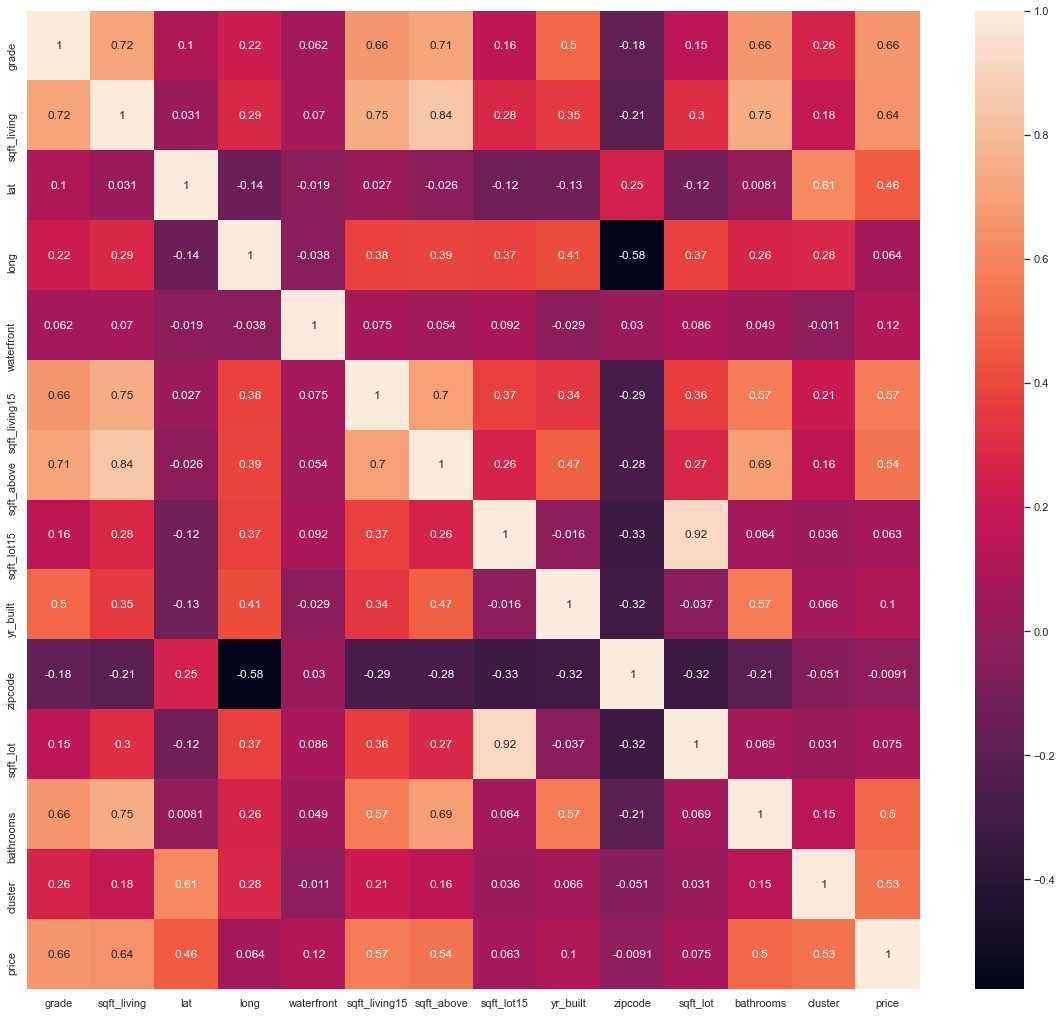

In [55]:
# Checking for correlation of columns to get an idea

corr_matrix = hsemodel2.corr(method = 'spearman')
fig, ax =  plt.subplots(figsize =(20,18))
ax = sns.heatmap(corr_matrix, annot = True)
plt.show()

In [56]:
# Running the regression on new model features
y = hsemodel2['price']
X = hsemodel2.drop(['price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [57]:
# Using the linear regression

lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train,y_train)

lm_predictions = lm_model.predict(X_test)

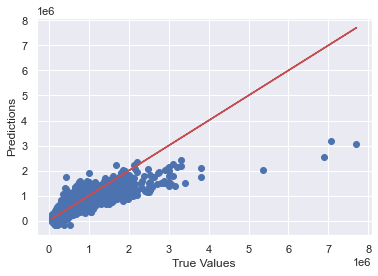

In [58]:
# Mapping the model using the y_test and predictions

plt.scatter(y_test, lm_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot(y_test,y_test,'r')

In [59]:
# Time to get our first model metrics to be used as a benchmark

MAE = mean_absolute_error(y_test,lm_predictions)
MSE = mean_squared_error(y_test,lm_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,lm_predictions)

print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.5f" % (R2))

The mean absolute error of the model in the test set is: 129517.17
The mean squared error of the model in the test set is: 48371484353.32
The root mean squared error of the model in the test set is: 219935.18
The R2 of the model in the test set is: 0.66963


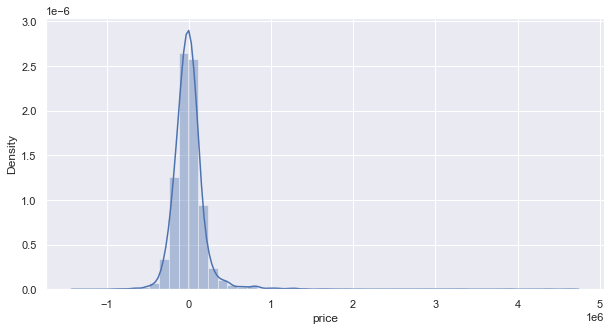

In [60]:
# PLotting of residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- lm_predictions)
sns.distplot(residuals)

In [61]:
#Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    
# Train the model on training data
rf.fit(X_train,y_train)   

RandomForestRegressor(n_estimators=1000, random_state=42)

In [62]:
# Use the forest's predict method on the test data
tree_predictions = rf.predict(X_test)

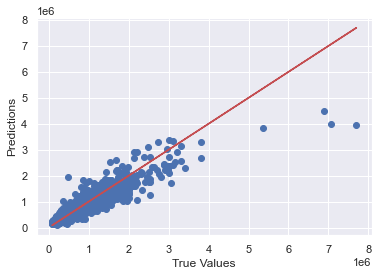

In [63]:
plt.scatter(y_test, tree_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot(y_test,y_test,'r')

In [64]:
MAE = mean_absolute_error(y_test,tree_predictions)
MSE = mean_squared_error(y_test,tree_predictions)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test,tree_predictions)

print("the mean absolut error of the model in the test set is: %6.2f" % (MAE))
print("the mean squared error of the model in the test set is: %6.2f" % (MSE))
print("the root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("the R2 of the model in the test set is: %6.2f" % (R2))

the mean absolut error of the model in the test set is: 71802.99
the mean squared error of the model in the test set is: 20201519513.28
the root mean squared error of the model in the test set is: 142132.05
the R2 of the model in the test set is:   0.86


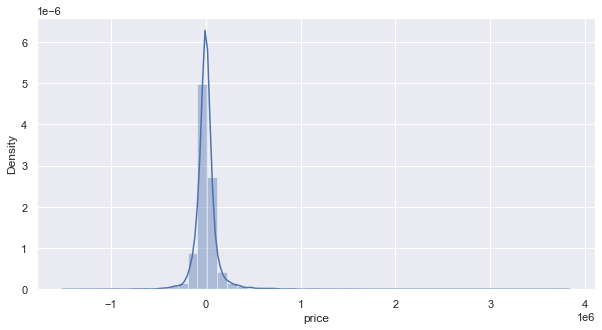

In [65]:
# PLotting of residuals
fig = plt.figure(figsize=(10,5))
residuals = (y_test- tree_predictions)
sns.distplot(residuals)

In [66]:
#Exporting data to csv
hsefinal.to_csv(r'Model_export_data_v1.csv')